In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import *

from sklearn.metrics import accuracy_score

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras import regularizers 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FIREBLZE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('spam_ham_dataset.csv')
data.info()
data=data.replace(to_replace ="ham",
                 value ="Legit")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


<AxesSubplot:xlabel='label', ylabel='count'>

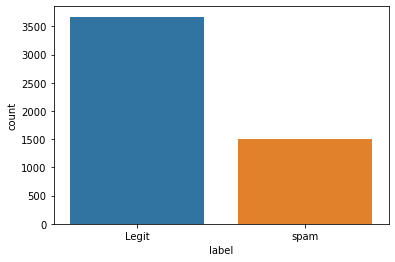

In [3]:
sns.countplot(x="label", data=data)

In [4]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9]:\S+|subject:\S+|nbsp"

In [5]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

data.text = data.text.apply(lambda x: preprocess(x))
data.head()


,Unnamed: 0,label,text,label_num
0,605,Legit,subject: enron methanol ; meter # : 988291 fol...,0
1,2349,Legit,"subject: hpl nom january 9 , 2001 ( see attach...",0
2,3624,Legit,"subject: neon retreat ho ho ho , ' around wond...",0
3,4685,spam,"subject: photoshop , windows , office . cheap ...",1
4,2030,Legit,subject: : indian springs deal book teco pvr r...,0


In [6]:
data = data.drop(['Unnamed: 0', 'label'], axis=1)
data = data.rename(columns = {"label_num" : "Label"})
data

,text,Label
0,subject: enron methanol ; meter # : 988291 fol...,0
1,"subject: hpl nom january 9 , 2001 ( see attach...",0
2,"subject: neon retreat ho ho ho , ' around wond...",0
3,"subject: photoshop , windows , office . cheap ...",1
4,subject: : indian springs deal book teco pvr r...,0
...,...,...
5166,subject: put 10 ft transport volumes decreased...,0
5167,subject: 3 / 4 / 2000 following noms hpl ' tak...,0
5168,subject: calpine daily gas nomination > > juli...,0
5169,subject: industrial worksheets august 2000 act...,0


In [7]:
x = data['text']
y = data['Label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25,
                                         random_state=7)
print("Train Data size:", len(x_train))
print("Test Data size", len(x_test))

Train Data size: 3878
Test Data size 1293


In [8]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1000
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 43372


In [9]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(x_train),
                        maxlen = 50)
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test),
                       maxlen = 50)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (3878, 50)
Testing X Shape: (1293, 50)


In [10]:
MAX_SEQUENCE_LENGTH = 50
n_lstm = 60
drop_lstm =0.2
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional, GRU
embeding_dim = 16
drop_value = 0.2
n_dense = 24
num_epochs = 20

In [11]:
#LSTM Spam detection architecture
lstm = Sequential()
lstm.add(Embedding(vocab_size, embeding_dim, input_length=MAX_SEQUENCE_LENGTH))
lstm.add(LSTM(7, dropout=drop_lstm,activity_regularizer=regularizers.l2(1e-4) ,return_sequences=False))
#lstm.add(LSTM(3, dropout=drop_lstm,activity_regularizer=regularizers.l2(1e-4) ,return_sequences=False))
lstm.add(Dense(1, activation='sigmoid'))
lstm.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
history = lstm.fit(x_train, y_train,validation_data=(x_test, y_test), epochs=num_epochs, verbose=2)
lstm.summary()


Epoch 1/20
122/122 - 3s - loss: 0.5396 - accuracy: 0.7127 - val_loss: 0.2858 - val_accuracy: 0.8175
Epoch 2/20
122/122 - 2s - loss: 0.1999 - accuracy: 0.9675 - val_loss: 0.2030 - val_accuracy: 0.9606
Epoch 3/20
122/122 - 2s - loss: 0.1172 - accuracy: 0.9897 - val_loss: 0.1429 - val_accuracy: 0.9652
Epoch 4/20
122/122 - 3s - loss: 0.0679 - accuracy: 0.9941 - val_loss: 0.1099 - val_accuracy: 0.9706
Epoch 5/20
122/122 - 2s - loss: 0.0413 - accuracy: 0.9969 - val_loss: 0.1042 - val_accuracy: 0.9691
Epoch 6/20
122/122 - 2s - loss: 0.0275 - accuracy: 0.9985 - val_loss: 0.1004 - val_accuracy: 0.9683
Epoch 7/20
122/122 - 3s - loss: 0.0195 - accuracy: 0.9987 - val_loss: 0.1067 - val_accuracy: 0.9667
Epoch 8/20
122/122 - 2s - loss: 0.0142 - accuracy: 0.9992 - val_loss: 0.1055 - val_accuracy: 0.9683
Epoch 9/20
122/122 - 2s - loss: 0.0108 - accuracy: 0.9995 - val_loss: 0.1137 - val_accuracy: 0.9675
Epoch 10/20
122/122 - 2s - loss: 0.0080 - accuracy: 0.9997 - val_loss: 0.1242 - val_accuracy: 0.9660

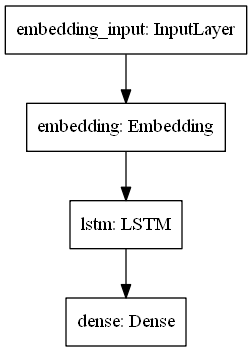

In [12]:
from keras_visualizer import visualizer 
from keras.utils import plot_model,model_to_dot

#visualizer(lstm,format='pdf', view=True)
plot_model(lstm, to_file='lstm_plot.png', show_layer_names=True,expand_nested=True)


In [13]:
trainPredict2 = lstm.predict(x_train, batch_size=256)
lstm.reset_states()
testPredict2 = lstm.predict(x_test, batch_size=256)
predicted2=np.concatenate((trainPredict2,testPredict2),axis=0)
Score = lstm.evaluate(x_test, y_test, verbose=100)
print("Our accuracy is %{}".format(Score[1]*100))



Our accuracy is %97.06109762191772


In [14]:
print(testPredict2.shape)

(1293, 1)


###  LSTM

#### TRAINING AND VALIDATION GRAPHS

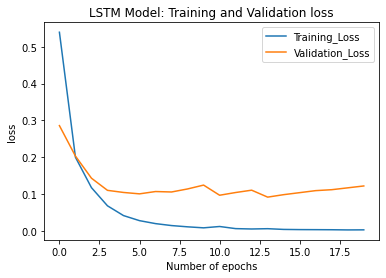

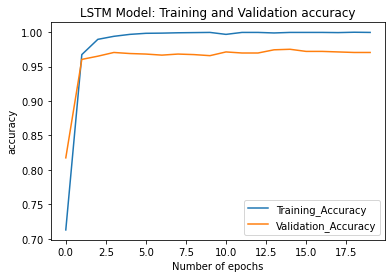

In [15]:
metrics = pd.DataFrame(history.history)

metrics.rename(columns= {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, 
               inplace = True)

def plot_graphs(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

plot_graphs('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

### P-R CURVE

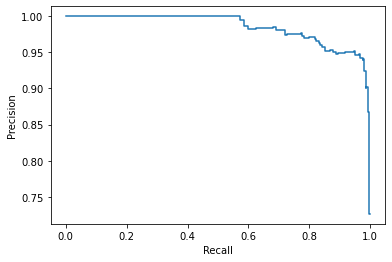

In [17]:
from sklearn.metrics import precision_recall_curve

p,r,_ = precision_recall_curve(y_test,testPredict2)
auc_score = auc(r, p)
disp = PrecisionRecallDisplay(precision=p, recall=r)
disp.plot()

In [19]:
print('ROC AUC: %f' % auc_score)

ROC AUC: 0.984447


In [ ]:
algo = ['ANN','RNN','LSTM','Bi-LSTM']
values = [91.98,74.16,format(Score[1]*100),97.37]
fig = plt.figure(figsize = (8,5))
 
# creating the bar plot
plt.bar(algo, values, color ='maroon',
        width = 0.4)


plt.ylabel("Score")
plt.title("Comparision of Accuracy")
plt.show()